# Algorithmic Bias - The Ethics of Using Algorithms for Sentencing

A statistical approach to understanding the implications of using algorithms for deciding prison sentences in America.

Author: Simbarashe Timire <> Date:06-12-2021 <> stimire92@gmail.com

## Introduction

As the world around us is increasingly becoming automated, from private institutions embarking on mass scale digitization projects in recruitment, advertising, and operations, to public organizations adopting emerging technologies with the aim of improving efficiency and objectivity in public decision making, the role played by algorithms on humanity has never been more fateful. We live in an era where algorithms not only influence the decisions we make on a daily basis, but also make decisions for us, decisions that directly or indirectly affect our lives in a fundamental way. Companies are using algorithms to select candidates for employment. Jugdes are using algorithms for sentencing. Politicians are using algorithms for voter profiling and targeting. 

Autonomous systems promised to be a magic bullet solution to discrimination and a path to a more equitable world, a world free of human bias and predijuce. But can algorithms actually be free of bias?

In this analysis, I show that, on top of the fact that autonomous systems inherit their creators biases, and can only be as fair as the data used to train them, it is sometimes impossible for algorithms to be fair even given unbiased inputs.

I use data made publicly available by Propublica on their [GitHub](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) page. Its a dataset on the results of Compas, a proprietary software which is used by judges in some parts of the USA to predict the chances that an arrested individual will re-offend. It then gives higher scores to those who are more likely to reoffend and low scores to those less likely. The judge then use this information to make decisions on the length of sentence the individual will get.


![Bias]("img/bias.png")

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import janitor
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## ICE

In [2]:
#reading in compas data
compas_df = pd.read_csv("compas-scores-two-years.csv").clean_names()
compas_df.head(3) #displaying the dataset

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count_1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1


In [3]:
#selecting the needed features
df = compas_df.loc[:,['age',
                      'c_charge_degree',
                      'race', 
                      'age_cat',
                      'score_text',
                      'sex', 
                      'priors_count', 
                      'days_b_screening_arrest', 
                      'decile_score', 
                      'is_recid', 
                      'two_year_recid', 
                      'c_jail_in', 
                      'c_jail_out']]

In [4]:
#filtering the dataset according to propublica recommendation
df_cl = df[((df["days_b_screening_arrest"]<=30) & 
            (df["days_b_screening_arrest"]>=-30) &
            (df["is_recid"]!=-1) &
            (df["c_charge_degree"]!="0") &
            (df["score_text"]!="N/A") &
            ((df["race"]=="African-American") |
            (df["race"]=="Caucasian"))
            )]

## Is this algorithm any good? 

There is 2 ways of looking at this.

1. Is the algorithm better than random? For the use of this algorithm to be justified, it has to be significantly better than just assigning scores at random.

2. Is the algorithm better than humans? This questions has so many dimentions, but two are important for this analysis. Is it more accurate than humans, if it is, is it consistent across groups? In other words is the algorithm fair?

To answer the first question, lets create 2 buckets called High, for High Risk and Low for Low Risk. Every individual with a compas score of 5 or higher, we put them in the High risk bucket, and the rest into the Low risk bucket.

If the Compass algorithm is no better than random guesses, then there will not be any statistically significant difference in the levels of reoffending between high risk bucket and low risk bucket. In other words individuals in the high risk bucket will re-offend just as often as those in low risk bucket.

In the following code I do a t-test to check if there is a difference in reoffending in the two buckets.

In [5]:
import warnings
warnings.filterwarnings('ignore') 
#Creating High and Low risk categories
df_cl['risk'] = np.where(df_cl['decile_score']>=5, 'High', 'Low')
#creating dataframes of low and high recidivism
high_score = df_cl['two_year_recid'].where(df_cl['risk'] == 'High').dropna()
low_score = df_cl['two_year_recid'].where(df_cl['risk'] == 'Low').dropna()
#running the t-test
res = stats.ttest_ind(a = high_score, b = low_score, equal_var = False)
#printing the t-test results
print( high_score.mean())
print(low_score.mean())
print(res)

0.6344554455445545
0.3200145296040683
Ttest_indResult(statistic=24.048833786753395, pvalue=2.874982603621933e-121)


The algorithm is actually better than a coin toss. Those who were given a high score (>5) by the compas algorithm have a 63.4% chance of re-offending while those with low scores have a 32% chance. The difference is statistically significant with (pvalue<0.001%)


We can also plot on a graph the mean recidivism rate of each score to getter a visual sense of whether the algorithm is better than random.

In [6]:
#This code block groups rows by decile scores and calcualtes the mean recidivism and other relevant statistics 
stats = df_cl.groupby(['decile_score'])['two_year_recid'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                  mean  count       std   ci95_hi   ci95_lo
decile_score                                               
1             0.219588    970  0.414181  0.245653  0.193522
2             0.307346    667  0.461740  0.342389  0.272304
3             0.386194    536  0.487331  0.427451  0.344937
4             0.441379    580  0.496980  0.481826  0.400933
5             0.476099    523  0.499907  0.518944  0.433255
6             0.585774    478  0.493104  0.629980  0.541568
7             0.607456    456  0.488853  0.652326  0.562587
8             0.722922    397  0.448120  0.767003  0.678841
9             0.720812    394  0.449170  0.765165  0.676460
10            0.812274    277  0.391200  0.858344  0.766205


Text(0, 0.5, 'Mean Recidivism 95% CI')

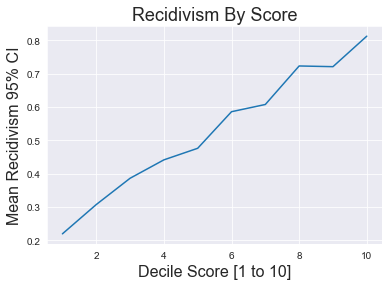

In [7]:
#This code block plots decile scores against mean recidivism
stats['decile_score'] = stats.index
plot_df = stats.loc[:,['decile_score', 'mean']]


sns.set_style('darkgrid')
d = pd.to_numeric(plot_df['mean'])
y1 = pd.to_numeric(plot_df['decile_score'])
sns.lineplot(data = plot_df, x = y1, y = d)
plt.rcParams['figure.dpi'] = 100
plt.title('Recidivism By Score', fontsize=18)
plt.xlabel('Decile Score [1 to 10]', fontsize=16)
plt.ylabel('Mean Recidivism 95% CI', fontsize=16)


It can be noted that recidivism rate increases as the scores given by the algorithm increase.For most scores, the conficence intervals do not overlap, we can conclude that in most cases, the difference in recidivism between scores is statistically significant. 

The compas algorithm is not perfect at predicting recidivism, but it is evidently way better than random guessing. 

## Is the algorithm fair?

There is so many dimensions to fairness, however in this analysis we will look at fairness with respect to race as this is one of the areas that have attracted a lot of attention in recent years. Movements like the Black Lives Matter and other issues around racial bias in policing, recruiting and sentencing warrant at least a formal analysis into some of the systems used almost ubiquitously to decide important aspects of our lives. Are algorithms the answer to racial discrimination or are they just as biased? If they are, is it by design or natuaral limitations? These questions form the basis for an enquiry into the mechanics of fairness as a mathematical problem. 

In [8]:
#recoding risk feature to 1 for high and 0 for low
df_cl['risk_2'] = np.where(df_cl['risk']=='High', 1, 0)


Are African Americans given a high risk score more often than Caucasians?

In [9]:
#
stats = df_cl.groupby(['race'])['risk_2'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                      mean  count       std   ci95_hi   ci95_lo
race                                                           
African-American  0.576063   3175  0.494258  0.593255  0.558871
Caucasian         0.330956   2103  0.470669  0.351072  0.310839


The answer is YES. The two groups are not equally likely to receive a high risk score (difference of 24.5%, p-value<0.001%). African Americans are way more likely to receive a high risk score. 

Could this be racial bias? 

Maybe this is an indication that the algorithm is racially biased.

OR

Maybe its just a reflection of African Americans' differential propensity to re-offend?

Luckily, we have a way to check that:

In [10]:
#Here we check if African Americans and Caucasians have a statistically different rate of re-offending.
stats = df_cl.groupby(['race'])['two_year_recid'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                     mean  count       std   ci95_hi   ci95_lo
race                                                          
African-American  0.52315   3175  0.499542  0.540526  0.505773
Caucasian         0.39087   2103  0.488061  0.411730  0.370010


Indeed, the result above shows that the two groups re-offend differently (with recidivism difference of 13.2%, p-value<0.001%). African Americans actually re-offend more than Caucasians. This now explains why they are also likely to recieve a high risk score from the algorithm. 

Now, is this higher propensity to re-offend due to race? This question has been widely researched and there is no evidence to suggest that the link between race and recidivism is causal. There is however a substantial amount of evidence that suggest that the two groups are deferentially exposed to risk factors that are known to be associated with recidivism (for example poor socioeconomic conditions).

Here is what we know at this point:
1. The algorithm is way better at predicting recidivism than random guesses,
2. African Americans are likely to receive a high risk score than Caucasians,
3. African Americans actually re-offend more than Caucasians.

But is this enough to say the algorithm is fair?

We can perhaps check this by doing 2 more analyses:
1. Fair predictions - do the scores predicted by the algorithm mean the same for the two groups. In other words, if a person gets a score of , say, 7, the propability of re-offending should be the same irrespective of their race.
2. Fair exposure to false positives - if the algorithm is fair, then we would want to see it making mistakes (type 1 errors) at the same rate to the two groups. 


## Fair Predictions

We are going to test if individuals who received a score of 7 had the same probability of reoffending.

In [11]:
#selecting data only for individuals given a score of 7
df_cl_f = df_cl[((df_cl["decile_score"]==7))]

In [12]:
# here we check if there is a difference in recidivism btwn the two groups (on people who were given a score of 7)
stats = df_cl_f.groupby(['race'])['two_year_recid'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                      mean  count       std   ci95_hi   ci95_lo
race                                                           
African-American  0.609329    343  0.488613  0.661039  0.557619
Caucasian         0.601770    113  0.491714  0.692433  0.511107


The result above shows that predictions for score 7 are fair (difference <1%, p-value 88.7%) for the two groups. 

Let’s check all scores graphically by plotting recidivism rate by score for the two groups (with 95% Confidence Intervals).

In [13]:
##
stats = df_cl.groupby(['decile_score', 'race'])['two_year_recid'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo


Text(0, 0.5, 'Mean Recidivism 95% CI')

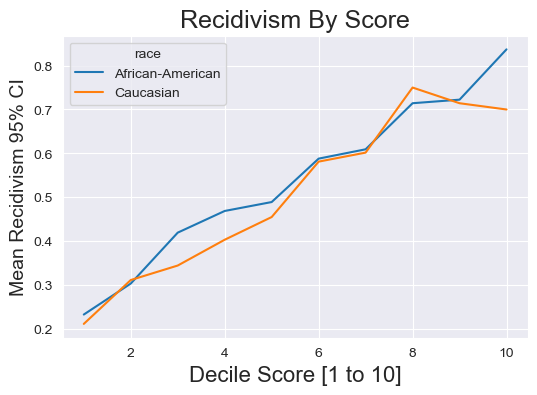

In [14]:
#plotting the graph of recidivism by score
stats['decile_score'] = stats.index
plot_df = stats.loc[:,['decile_score', 'mean']]
mean = pd.DataFrame(plot_df['mean'])
df_f = mean['mean'].reset_index()
#df_f.head(6)

sns.set_style('darkgrid')
d = pd.to_numeric(df_f['mean'])
y1 = pd.to_numeric(df_f['decile_score'])
sns.lineplot(data = df_f, x = y1, y = d, hue = 'race')
plt.rcParams['figure.dpi'] = 100
plt.title('Recidivism By Score', fontsize=18)
plt.xlabel('Decile Score [1 to 10]', fontsize=16)
plt.ylabel('Mean Recidivism 95% CI', fontsize=14)

The confidence interval overlap for almost every score. 

Therefore we can conclude that there is no evidence to suggest that Compas is biased based on predictions – African Americans and Caucasians of the same score have the same probability of re-offending.

It turns out the algorithm is fair based on predictions.

What about exposure to false positives? Do African Americans sytematically get more false positives than Caucasians?

## Fair Exposure to False Positives

If the algorithm is fair, then we would also want it to expose the two groups to a similar rate of false positives. That is, the probability of awarding a high risk score to an African American who does not go on to re-offend (a false positive) should be the same as the probability of awarding a high score to a Caucasian who does not re-offend.

Let’s check

In [15]:
df_cl_fp = df_cl[((df_cl["two_year_recid"]==0))]

In [16]:
stats = df_cl_fp.groupby(['race'])['risk_2'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                      mean  count       std   ci95_hi   ci95_lo
race                                                           
African-American  0.423382   1514  0.494258  0.448279  0.398485
Caucasian         0.220141   1281  0.414503  0.242840  0.197441


African Americans are almost twice as likely to be given a false positive than Caucasians (difference of 20.3%, p-value<0.001%).

**This is NOT fair!!**


However, this is an inevitable consequence of the fact that

African Americans have a higher recidivism rate than Caucasians (about 52% vs 39%).

The algorithm is fair based on predictions (people with a score of 4 or above have 63% chance of re-offending irrespective of race).

To see this, lets start with a sample of 100 representative African Americans and 100 representative Caucasians. As we have seen before, out of 100 African Americans, ~58 will be given a high score. Since the algorithm is right 63% of the time when it gives a high score (and it is wrong 37% of the time) then 37%x58=21 African Americans will be given a false positive. Similarly, 33 Caucasians will be given a high score and 37%x33=12 of them will be false positives. Therefore 21% of African Americans will be exposed to false positive vs 12% of Caucasians.

The conclusion is that there are mathematical limitations to fairness. Although Compas is fair based on predictions it is not fair based on exposure to false positives. This does constitute discrimination against African Americans. If we were to change Compas to make it fair based on exposure to false positives it would no longer be fair based on predictions. Algorithms are therefore not the magic solution to discrimination, even if they are built with the best intentions and are trained based on representative data (and often they are not!).

The question now is:

Are algorithms fairer than human beings?

Or is it a question of whether to use algorithms or we just use human judgement? which one is more biased? 

I think the answer lies somewhere inbetween the two, algorithms are not perfect, they can only be there to complement human judgement as opposed to eliminating it.